In [55]:
#importing libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
%matplotlib inline

# Прочитаем датасет и проведем разведочный анализ

In [17]:
data = pd.read_csv("/home/vi/Downloads/MGTU/practical case/Датасет к Практическому заданию/ebw_data.csv")
data.head()  

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


Параметры:
величина сварочного тока (IW);
ток фокусировки электронного пучка (IF);
скорость сварки (VW);
расстояние от поверхности образцов до электронно-оптической системы (FP).

In [18]:
data.shape 

(72, 6)

In [19]:
data.info()  #No NaNs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [20]:
data.describe() #Dataset statistics

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


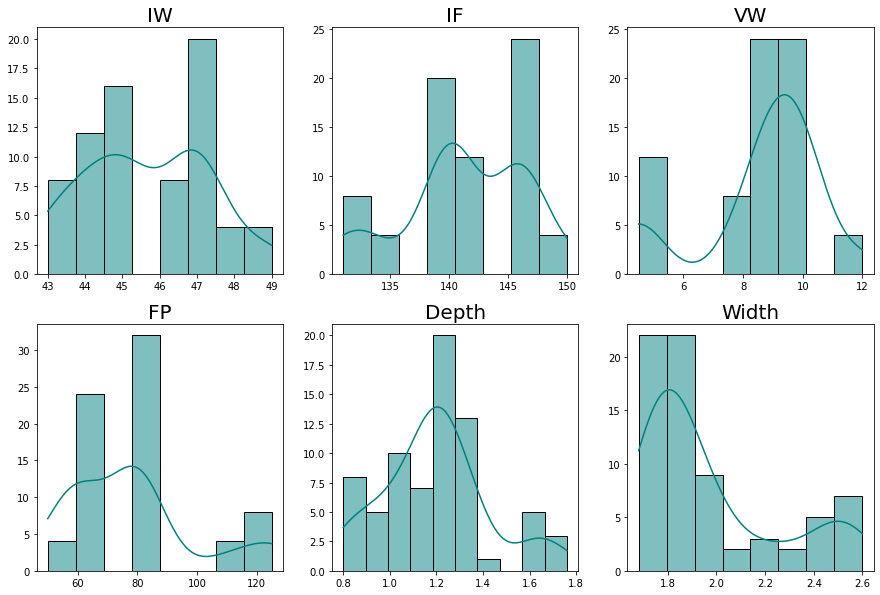

In [125]:
counter = 1     #The distribution of the values in features
plt.figure(figsize = (15,10))
for col in data.columns:
    plt.subplot(2, 3, counter)
    sns.histplot(data = data[col], kde = True, color = "teal")
    plt.ylabel(ylabel = None)
    plt.xlabel(xlabel = None)
    plt.title(col, size = 20)
    counter += 1 

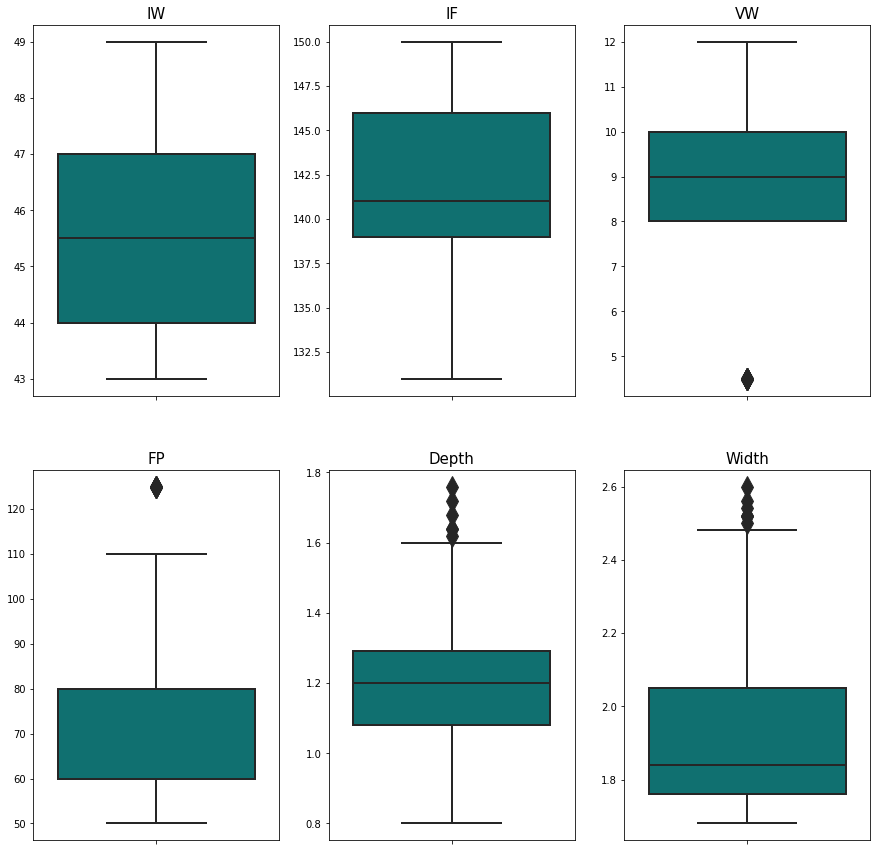

In [127]:
#Boxplots of our data. The data points that are located outside the whiskers of the boxplot are outliers.
counter = 1
plt.figure(figsize = (15,15))

for col in data.columns:
    plt.subplot(2, 3, counter)
    sns.boxplot(data = data, y = data[col], fliersize = 15, linewidth = 2, color = 'teal')
    plt.ylabel(ylabel = None)
    plt.title(col, size = 15)
    counter += 1

То, что тут выглядит, как выбросы, на самом деле скорее всего ими не является: во-первых, у нас довольно много 
таких значений, а не одно, во-вторых, сам датасет очень маленький, поэтому мы не будем их отбрасывать.

In [ ]:
sns.pairplot(data, diag_kind = 'kde')
#Pairplots of features in the dataset against each other to check for possible correlation

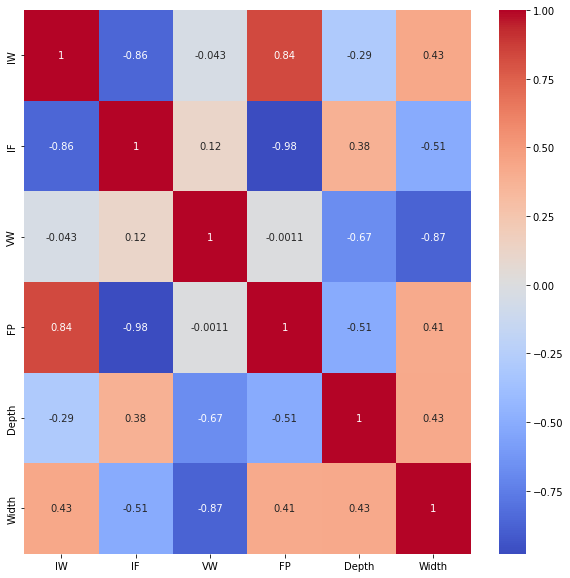

In [23]:
# A heatmap of correlation between the features in the dataset. 
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),cmap = 'coolwarm',annot = True) #correlation matrix
plt.show()

Видно, что есть некоторая значительная корреляция между IW и IF,IW и FP,IF и FP, VW и Width.
Но так как у нас очень маленький датасет, не будем исключать из него данные.

# Подготовим датасет к анализу

In [24]:
X = data.drop(["Width", "Depth"], axis=1)
Y = data[["Width", "Depth"]].copy() 
#We will use models that allow prediction of 2 targets, so Y will contain both targets - Width and Depth

In [25]:
X.describe()

,IW,IF,VW,FP
count,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333
std,1.678363,5.145763,2.061078,21.493530
min,43.000000,131.000000,4.500000,50.000000
25%,44.000000,139.000000,8.000000,60.000000
50%,45.500000,141.000000,9.000000,80.000000
75%,47.000000,146.000000,10.000000,80.000000
max,49.000000,150.000000,12.000000,125.000000


In [56]:
random_state = 0
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    random_state=random_state, 
                                                    shuffle=True)
#Splitting into test and train subsets

In [57]:
scaler = MinMaxScaler()   #Normalizing x
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
X_train[:5]  

array([[0.        , 1.        , 0.6       , 0.        ],
       [0.33333333, 0.78947368, 0.6       , 0.13333333],
       [0.        , 0.78947368, 0.6       , 0.13333333],
       [0.66666667, 0.47368421, 0.73333333, 0.4       ],
       [0.33333333, 0.47368421, 0.        , 0.4       ]])

In [59]:
X_train.shape, Y_train.shape #The datasets are split correctly

((57, 4), (57, 2))

In [60]:
models = pd.DataFrame(columns = ['model', 'test_score', 'cross_val_score', "W MAE", "W MSE", "W RMSE", "D MAE", "D MSE", 'D RMSE'])
#preparing a dataset that will contain the results of our models

# Построим модели и оценим их эффективность

### DecisionTreeRegressor

Подберем гиперпараметр max_depth и посчитаем score на тестовой выборке, а также методом кросс-валидации.

In [61]:
scores_data1 = pd.DataFrame()
max_depth_values = range(2, 50)
for max_depth in max_depth_values:
    clf = MultiOutputRegressor(tree.DecisionTreeRegressor(max_depth = max_depth, random_state=random_state))
    clf.fit(X_train,Y_train)
    train_score = clf.score(X_train,Y_train)
    test_score = clf.score(X_test,Y_test)
    mean_cross_val_score = cross_val_score(clf, X_train,Y_train, cv = 5).mean() #mean score with 5 fold cross validation
    temp = pd.DataFrame({'max_depth':[max_depth],'train_score':[train_score], 'test_score':[test_score],'cross_val_score':[mean_cross_val_score]})
    scores_data1 = pd.concat([scores_data1, temp])
scores_data1.reset_index(inplace=True)
scores_data1 = scores_data1.drop(['index'], axis = 1)
scores_data1.head()

,max_depth,train_score,test_score,cross_val_score
0,2,0.875143,0.821104,0.804905
1,3,0.915965,0.859209,0.861128
2,4,0.948426,0.859908,0.906209
3,5,0.962584,0.864219,0.911352
4,6,0.965107,0.859223,0.911229


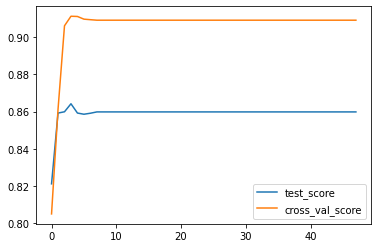

In [62]:
# Plotting the score results for different depths.
plt.plot(scores_data1['test_score'], label = 'test_score')
plt.plot(scores_data1['cross_val_score'], label = 'cross_val_score')
plt.legend()   

Тот факт, что score на кросс валидации выше, может означать, что наша модель переобучается.

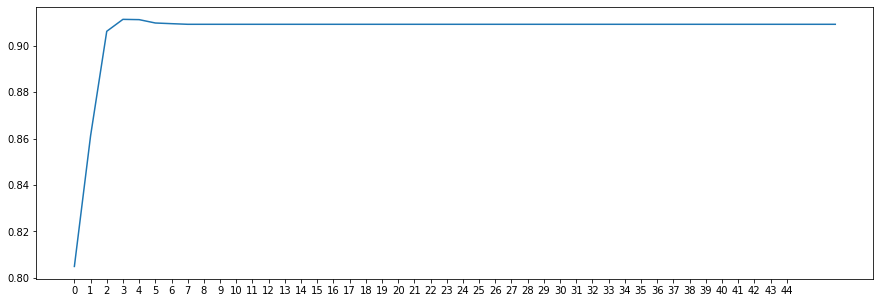

In [63]:
plt.figure(figsize = (15,5))
plt.xticks(np.arange(0,45, 1.0))
plt.plot(scores_data1['cross_val_score'])  

На графике четко видно, что есть значение max_depth, при котором достигается максимальная точность модели.

In [64]:
scores_data1['cross_val_score'].max()  #Our model reaches the best score when max_depth = 5

0.9113516295360542

In [65]:
model = MultiOutputRegressor(tree.DecisionTreeRegressor(max_depth = 5, random_state=random_state)) 

In [66]:
model.fit(X_train, Y_train) #Training the model

MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=5,
                                                     random_state=0))

In [67]:
Y_pred = model.predict(X_test) 

In [68]:
Y_pred 

array([[1.97      , 0.96      ],
       [1.97      , 0.96      ],
       [1.79470588, 1.22      ],
       [1.70333333, 1.12      ],
       [2.528     , 1.568     ],
       [1.79470588, 1.22      ],
       [2.49333333, 1.70666667],
       [1.79470588, 1.22      ],
       [2.1       , 0.82      ],
       [1.79470588, 1.30857143],
       [1.79470588, 1.22      ],
       [2.528     , 1.568     ],
       [2.528     , 1.568     ],
       [1.79470588, 1.17333333],
       [2.1       , 0.82      ]])

In [69]:
Y_test_num = Y_test.to_numpy() #DataFrame to numpy array

In [70]:
Y_test_num

array([[1.86, 0.92],
       [1.94, 0.94],
       [1.8 , 1.28],
       [1.8 , 1.2 ],
       [2.48, 1.4 ],
       [1.96, 1.32],
       [2.56, 1.64],
       [1.76, 1.2 ],
       [2.  , 0.88],
       [1.76, 1.32],
       [1.76, 1.2 ],
       [2.52, 1.36],
       [2.48, 1.36],
       [1.8 , 1.12],
       [2.08, 0.86]])

In [71]:
Y_test_num[:,1] #Test data for Depth

array([0.92, 0.94, 1.28, 1.2 , 1.4 , 1.32, 1.64, 1.2 , 0.88, 1.32, 1.2 ,
       1.36, 1.36, 1.12, 0.86])

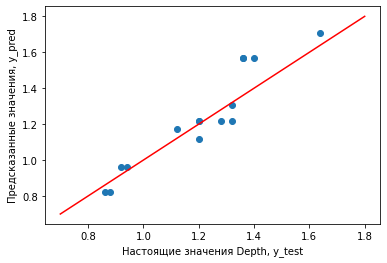

In [72]:
ax = plt.axes()  #Plot of predicted Depth against test Depth
ax.scatter(Y_test_num[:, 1], Y_pred[:, 1])
ax.plot([0.7, 1.8], [0.7,1.8], color = 'r')
plt.xlabel("Настоящие значения Depth, y_test")
plt.ylabel("Предсказанные значения, y_pred")
plt.show()

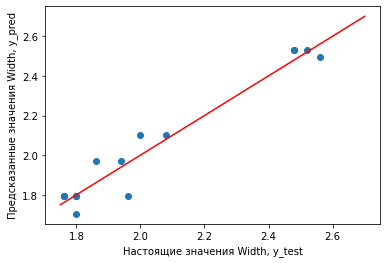

In [73]:
ax = plt.axes() #Plot of predicted Width against test Width
ax.scatter(Y_test_num[:, 0], Y_pred[:, 0])
ax.plot([1.75, 2.7], [1.75, 2.7], color = 'r')
plt.xlabel("Настоящие значения Width, y_test")
plt.ylabel("Предсказанные значения Width, y_pred")
plt.show()

In [74]:
model.get_params(deep=True)

{'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': 5,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': 0,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeRegressor(max_depth=5, random_state=0),
 'n_jobs': None}

In [75]:
print('Width Mean Absolute Error:', metrics.mean_absolute_error(Y_test_num[:, 0], Y_pred[:, 0]))
print('Width Mean Squared Error:', metrics.mean_squared_error(Y_test_num[:, 0], Y_pred[:, 0]))
print('Width Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(Y_test_num[:, 0], Y_pred[:, 0])))
print("Width mean:", data["Width"].mean())

Width Mean Absolute Error: 0.05382222222222223
Width Mean Squared Error: 0.0048568389593745985
Width Root Mean Squared Error: 0.06969102495568995
Width mean: 1.9704166666666667


In [76]:
model.score(X_test,Y_test_num) #The r2 score of our model in general

0.8642185087084622

In [77]:
metrics.max_error(Y_test_num[:, 0], Y_pred[:, 0]) #The worst error of the model for Width

0.1652941176470588

In [78]:
print('Depth Mean Absolute Error:', metrics.mean_absolute_error(Y_test_num[:, 1], Y_pred[:, 1]))
print('Depth Mean Squared Error:', metrics.mean_squared_error(Y_test_num[:, 1], Y_pred[:, 1]))
print('Depth Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(Y_test_num[:, 1], Y_pred[:, 1])))
print("Depth mean:", data["Depth"].mean())

Depth Mean Absolute Error: 0.07702857142857142
Depth Mean Squared Error: 0.010011433408919123
Depth Root Mean Squared Error: 0.10005715071357531
Depth mean: 1.1955555555555555


In [79]:
metrics.max_error(Y_test_num[:, 1], Y_pred[:, 1]) #The worst error of the model for Depth

0.20799999999999996

In [80]:
#Saving the results for the first model
temp = pd.DataFrame({'model': ['DecisionTreeRegressor'],'test_score': [scores_data1['test_score'].max()], 'cross_val_score': [scores_data1['cross_val_score'].max()], "W MAE": [metrics.mean_absolute_error(Y_test_num[:, 0], Y_pred[:, 0])], "W MSE": [metrics.mean_squared_error(Y_test_num[:, 0], Y_pred[:, 0])],
                     'W RMSE': [np.sqrt(metrics.mean_squared_error(Y_test_num[:, 0], Y_pred[:, 0]))], "D MAE": [metrics.mean_absolute_error(Y_test_num[:, 1], Y_pred[:, 1])], "D MSE":[metrics.mean_squared_error(Y_test_num[:, 1], Y_pred[:, 1])], 'D RMSE': np.sqrt(metrics.mean_squared_error(Y_test_num[:, 1], Y_pred[:, 1])) })
models = pd.concat([models, temp])
models

,model,test_score,cross_val_score,W MAE,W MSE,W RMSE,D MAE,D MSE,D RMSE
0,DecisionTreeRegressor,0.864219,0.911352,0.053822,0.004857,0.069691,0.077029,0.010011,0.100057


### RandomForestRegressor

Подберем лучший гиперпараметр max_depth

In [82]:
scores_data2 = pd.DataFrame()
max_depth_values = range(5, 50)
for max_depth in max_depth_values:
    clf = MultiOutputRegressor(RandomForestRegressor(max_depth = max_depth, random_state=random_state))
    clf.fit(X_train,Y_train)
    train_score = clf.score(X_train,Y_train)
    test_score = clf.score(X_test,Y_test)
    mean_cross_val_score = cross_val_score(clf, X_train,Y_train, cv = 5).mean() 
    temp = pd.DataFrame({'max_depth':[max_depth],'train_score':[train_score], 'test_score':[test_score],'cross_val_score':[mean_cross_val_score]})
    scores_data2 = pd.concat([scores_data2, temp])
scores_data2.reset_index(inplace=True)
scores_data2 = scores_data2.drop(['index'], axis = 1)
scores_data2.head()

,max_depth,train_score,test_score,cross_val_score
0,5,0.964878,0.875369,0.909612
1,6,0.966140,0.873120,0.908673
2,7,0.966309,0.872314,0.908294
3,8,0.966349,0.872738,0.908161
4,9,0.966344,0.872482,0.908119


In [83]:
scores_data2['cross_val_score'].max() #Best cross validation score for RandomForestRegressor is at max_depth = 5

0.9096124832332547

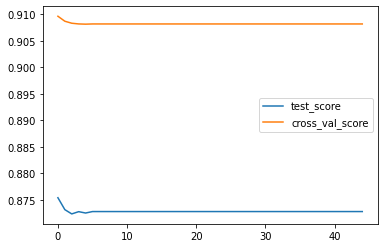

In [85]:
plt.plot(scores_data2['test_score'], label = 'test_score')
plt.plot(scores_data2['cross_val_score'], label = 'cross_val_score')
plt.legend()

In [88]:
model2 = MultiOutputRegressor(RandomForestRegressor(max_depth = 5, random_state=random_state))

In [89]:
model2.fit(X_train, Y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=5,
                                                     random_state=0))

In [90]:
y_pred_model2 = model2.predict(X_test)

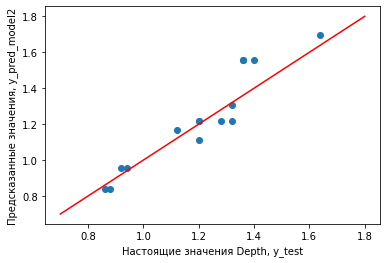

In [91]:
ax = plt.axes()
ax.scatter(Y_test_num[:, 1], y_pred_model2[:, 1])
ax.plot([0.7, 1.8], [0.7,1.8], color = 'r')
plt.xlabel("Настоящие значения Depth, y_test")
plt.ylabel("Предсказанные значения, y_pred_model2")
plt.show()

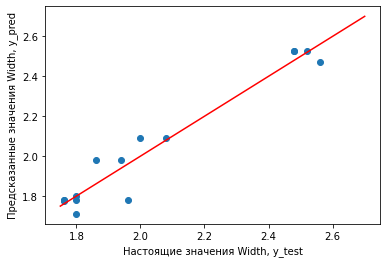

In [92]:
ax = plt.axes()
ax.scatter(Y_test_num[:, 0], y_pred_model2[:, 0])
ax.plot([1.75, 2.7], [1.75, 2.7], color = 'r')
plt.xlabel("Настоящие значения Width, y_test")
plt.ylabel("Предсказанные значения Width, y_pred")
plt.show()

In [93]:
model2.score(X_test,Y_test_num) #model r2 score

0.8753692283715393

In [94]:
metrics.max_error(Y_test_num[:, 0],  y_pred_model2[:, 0]) #Worst error for Width

0.18136301584139503

In [95]:
print('Width Mean Absolute Error:', metrics.mean_absolute_error(Y_test_num[:, 0], y_pred_model2[:, 0]))
print('Width Mean Squared Error:', metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model2[:, 0]))
print('Width Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model2[:, 0])))
print("Width mean:", data["Width"].mean())

Width Mean Absolute Error: 0.05267914643576317
Width Mean Squared Error: 0.005222393890508461
Width Root Mean Squared Error: 0.07226613238930434
Width mean: 1.9704166666666667


In [96]:
print('Depth Mean Absolute Error:', metrics.mean_absolute_error(Y_test_num[:, 1], y_pred_model2[:, 1]))
print('Depth Mean Squared Error:', metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model2[:, 1]))
print('Depth Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model2[:, 1])))
print("Depth mean:", data["Depth"].mean())

Depth Mean Absolute Error: 0.07068105176305156
Depth Mean Squared Error: 0.008797732808897013
Depth Root Mean Squared Error: 0.09379623024885922
Depth mean: 1.1955555555555555


In [97]:
metrics.max_error(Y_test_num[:, 1], y_pred_model2[:, 1]) #Worst error for Depth

0.1955436507936501

In [98]:
temp = pd.DataFrame({'model': ['RandomForestRegressor'],'test_score': [scores_data2['test_score'].max()], 'cross_val_score': [scores_data2['cross_val_score'].max()], "W MAE": [metrics.mean_absolute_error(Y_test_num[:, 0], y_pred_model2[:, 0])], "W MSE": [metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model2[:, 0])],
                     'W RMSE': [np.sqrt(metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model2[:, 0]))], "D MAE": [metrics.mean_absolute_error(Y_test_num[:, 1], y_pred_model2[:, 1])], "D MSE":[metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model2[:, 1])], 'D RMSE': np.sqrt(metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model2[:, 1])) })
models = pd.concat([models, temp])
models


,model,test_score,cross_val_score,W MAE,W MSE,W RMSE,D MAE,D MSE,D RMSE
0,DecisionTreeRegressor,0.864219,0.911352,0.053822,0.004857,0.069691,0.077029,0.010011,0.100057
0,RandomForestRegressor,0.875369,0.909612,0.052679,0.005222,0.072266,0.070681,0.008798,0.093796


### KNeighborsRegressor

Подберем гиперпараметр n_neighbors

In [99]:
scores_data3 = pd.DataFrame()
max_n_neighbors = range(2, 30)
for n_neighbors in max_n_neighbors:
    clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=n_neighbors))
    clf.fit(X_train,Y_train)
    train_score = clf.score(X_train,Y_train)
    test_score = clf.score(X_test,Y_test)
    mean_cross_val_score = cross_val_score(clf, X_train,Y_train, cv = 5).mean() 
    temp = pd.DataFrame({'n_neighbors':[n_neighbors],'train_score':[train_score], 'test_score':[test_score],'cross_val_score':[mean_cross_val_score]})
    scores_data3 = pd.concat([scores_data3, temp])
scores_data3.reset_index(inplace=True)
scores_data3 = scores_data3.drop(['index'], axis = 1)
scores_data3.head()

,n_neighbors,train_score,test_score,cross_val_score
0,2,0.956114,0.785164,0.894730
1,3,0.960403,0.886732,0.891402
2,4,0.960281,0.871463,0.884677
3,5,0.950835,0.855129,0.866972
4,6,0.941948,0.812915,0.827745


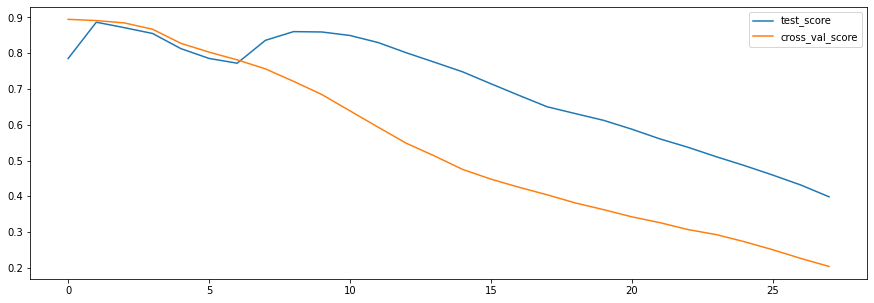

In [100]:
plt.figure(figsize = (15,5))
plt.plot(scores_data3['test_score'], label = 'test_score')
plt.plot(scores_data3['cross_val_score'], label = 'cross_val_score')
plt.legend()

На этом графике хорошо видна точка, с которой начинается переобучение модели.

In [101]:
scores_data3.loc[0:4,:]

,n_neighbors,train_score,test_score,cross_val_score
0,2,0.956114,0.785164,0.894730
1,3,0.960403,0.886732,0.891402
2,4,0.960281,0.871463,0.884677
3,5,0.950835,0.855129,0.866972
4,6,0.941948,0.812915,0.827745


In [102]:
scores_data3['cross_val_score'].max() 

0.8947303558666226

In [ ]:
Лучший результат достигается при n_neighbors=2,но он почти неотличим от результата при n_neighbors=3,
а брать двух соседей плохо, так как велика вероятность случаев, когда два разных соседа приведут к неопределенности

In [103]:
model3 = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=3))

In [104]:
model3.fit(X_train, Y_train)

MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=3))

In [105]:
y_pred_model3 = model3.predict(X_test)

In [106]:
model3.score(X_test,Y_test_num) 

0.8867322498035627

In [107]:
temp = pd.DataFrame({'model': ['KNeighborsRegressor'],'test_score': [scores_data3['test_score'].max()], 'cross_val_score': [scores_data3['cross_val_score'].max()], "W MAE": [metrics.mean_absolute_error(Y_test_num[:, 0], y_pred_model3[:, 0])], "W MSE": [metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model3[:, 0])],
                     'W RMSE': [np.sqrt(metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model3[:, 0]))], "D MAE": [metrics.mean_absolute_error(Y_test_num[:, 1], y_pred_model3[:, 1])], "D MSE":[metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model3[:, 1])], 'D RMSE': np.sqrt(metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model3[:, 1])) })
models = pd.concat([models, temp])
models

,model,test_score,cross_val_score,W MAE,W MSE,W RMSE,D MAE,D MSE,D RMSE
0,DecisionTreeRegressor,0.864219,0.911352,0.053822,0.004857,0.069691,0.077029,0.010011,0.100057
0,RandomForestRegressor,0.875369,0.909612,0.052679,0.005222,0.072266,0.070681,0.008798,0.093796
0,KNeighborsRegressor,0.886732,0.894730,0.053556,0.005310,0.072872,0.067111,0.007707,0.087788


### LinearRegression

In [110]:
model4 = MultiOutputRegressor(LinearRegression())

In [111]:
model4.fit(X_train, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [112]:
y_pred_model4 = model4.predict(X_test)

In [113]:
model4.score(X_test,Y_test_num) 

0.7361541029067603

In [114]:
mean_cross_val_score = cross_val_score(model4, X_train,Y_train, cv = 5).mean() 
mean_cross_val_score

0.8308586551190524

In [115]:
temp = pd.DataFrame({'model': ['LinearRegression'],'test_score': [model4.score(X_test,Y_test_num)], 'cross_val_score': [mean_cross_val_score], "W MAE": [metrics.mean_absolute_error(Y_test_num[:, 0], y_pred_model4[:, 0])], "W MSE": [metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model4[:, 0])],
                     'W RMSE': [np.sqrt(metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model4[:, 0]))], "D MAE": [metrics.mean_absolute_error(Y_test_num[:, 1], y_pred_model4[:, 1])], "D MSE":[metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model4[:, 1])], 'D RMSE': np.sqrt(metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model4[:, 1])) })
models = pd.concat([models, temp])
models

,model,test_score,cross_val_score,W MAE,W MSE,W RMSE,D MAE,D MSE,D RMSE
0,DecisionTreeRegressor,0.864219,0.911352,0.053822,0.004857,0.069691,0.077029,0.010011,0.100057
0,RandomForestRegressor,0.875369,0.909612,0.052679,0.005222,0.072266,0.070681,0.008798,0.093796
0,KNeighborsRegressor,0.886732,0.894730,0.053556,0.005310,0.072872,0.067111,0.007707,0.087788
0,LinearRegression,0.736154,0.830859,0.064225,0.006597,0.081221,0.114360,0.020909,0.144599


## XGBRegressor

In [116]:
model5 = XGBRegressor()

In [117]:
model5.fit(X_test,Y_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [118]:
y_pred_model5 = model5.predict(X_test)

In [119]:
model5.score(X_test, Y_test_num)

0.9782457348514875

In [120]:
model5.get_metadata_routing()

{'fit': {'sample_weight': None, 'base_margin': None, 'eval_set': None, 'eval_metric': None, 'early_stopping_rounds': None, 'verbose': None, 'xgb_model': None, 'sample_weight_eval_set': None, 'base_margin_eval_set': None, 'feature_weights': None, 'callbacks': None}, 'predict': {'output_margin': None, 'ntree_limit': None, 'validate_features': None, 'base_margin': None, 'iteration_range': None}, 'score': {'sample_weight': None}}

In [121]:
mean_cross_val_score5 = cross_val_score(model5, X_train,Y_train, cv = 5).mean() 
mean_cross_val_score5 

0.9097765412701797

In [122]:
temp = pd.DataFrame({'model': ['XGBRegressor'],'test_score': [model5.score(X_test,Y_test_num)], 'cross_val_score': [mean_cross_val_score5], "W MAE": [metrics.mean_absolute_error(Y_test_num[:, 0], y_pred_model5[:, 0])], "W MSE": [metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model5[:, 0])],
                     'W RMSE': [np.sqrt(metrics.mean_squared_error(Y_test_num[:, 0], y_pred_model5[:, 0]))], "D MAE": [metrics.mean_absolute_error(Y_test_num[:, 1], y_pred_model5[:, 1])], "D MSE":[metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model5[:, 1])], 'D RMSE': np.sqrt(metrics.mean_squared_error(Y_test_num[:, 1], y_pred_model5[:, 1])) })
models = pd.concat([models, temp])
models

,model,test_score,cross_val_score,W MAE,W MSE,W RMSE,D MAE,D MSE,D RMSE
0,DecisionTreeRegressor,0.864219,0.911352,0.053822,0.004857,0.069691,0.077029,0.010011,0.100057
0,RandomForestRegressor,0.875369,0.909612,0.052679,0.005222,0.072266,0.070681,0.008798,0.093796
0,KNeighborsRegressor,0.886732,0.894730,0.053556,0.005310,0.072872,0.067111,0.007707,0.087788
0,LinearRegression,0.736154,0.830859,0.064225,0.006597,0.081221,0.114360,0.020909,0.144599
0,XGBRegressor,0.978246,0.909777,0.033289,0.002312,0.048081,0.019897,0.000818,0.028608


## Результаты

Мы проанализировали маленький датасет с двумя целевыми переменными, проверили его на пропуски данных и выбросы,
а также на распределение данных и корреляцию между ними.
Мы рассмотрели 5 разных регрессоров, позволяющих нам иметь две целевые переменные, используя разбиение датасета на 
обучающую и тестовую выборки, а также используя метод кросс-валидации. Предварительно данные были нормализованы.
Для каждой из моделей мы рассчитали основные метрики, а именно:
test_score - коэффициент детерминации r2 score (coefficient of determination) на тестовой выборке. Этот параметр 
показывает, насколько дисперсия целевой переменной объясняется входными данными при использовании нашей модели.
cross_val_score - среднее значение коэффициента детерминации r2 score (coefficient of determination)
при кросс валидации с разбивкой на 5 фолдов.
W MAE - средняя абсолютная ошибка при определении ширины.
W MSE - среднеквадратическая ошибка при определении ширины.
W RMSE - корень среднеквадратической ошибки при определении ширины.
D MAE - средняя абсолютная ошибка при определении длины. 
D MSE - среднеквадратическая ошибка при определении длины.
D RMSE - корень среднеквадратической ошибки при определении длины.

In [128]:
models.reset_index(inplace=True)
models = models.drop(['index'], axis = 1)
models
#reindexing

,model,test_score,cross_val_score,W MAE,W MSE,W RMSE,D MAE,D MSE,D RMSE
0,DecisionTreeRegressor,0.864219,0.911352,0.053822,0.004857,0.069691,0.077029,0.010011,0.100057
1,RandomForestRegressor,0.875369,0.909612,0.052679,0.005222,0.072266,0.070681,0.008798,0.093796
2,KNeighborsRegressor,0.886732,0.894730,0.053556,0.005310,0.072872,0.067111,0.007707,0.087788
3,LinearRegression,0.736154,0.830859,0.064225,0.006597,0.081221,0.114360,0.020909,0.144599
4,XGBRegressor,0.978246,0.909777,0.033289,0.002312,0.048081,0.019897,0.000818,0.028608


Модель, показавшая наилучший коэффициент детерминации при кросс валидации - DecisionTreeRegressor, то есть 
эта модель наилучшим образом объясняет дисперсия целевых переменных, используя входными данными, 
а наихудшей моделью оказалась LinearRegression.
При этом модель, имевшая наименьшие показатели ошибок при определении длины и ширины - XGBRegressor. Эта модель 
совершила меньше ошибок, чем все остальные из протестированных.
Хуже всего с этой задачей справилась LinearRegression.

На основании полученных данных можно сделать вывод о том, что XGBRegressor точнее предсказывает целевые переменные.